> Add Constriction for The Decrease of 'var':
    
            if self.var > 0.2:
                self.var *= 0.99995

In [1]:
TRAIN = 0

In [2]:
"""
View more on the tutorial page: https://morvanzhou.github.io/tutorials/
"""

import tensorflow as tf
import numpy as np
import manipulator

# # # reproducible
np.random.seed(1)
tf.set_random_seed(1)

#####################  hyper parameters  ####################


MAX_EP_STEPS = 500
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

RENDER = False

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()
                
        if TRAIN:
            self.var = 3.0
        else:
            self.var = 0.0        
            
#         self.mean = np.array([0.]*26, dtype=np.float32)
        
#         self.std = np.array([1.]*26, dtype=np.float32)    
        
#         self.sum_ai2 = np.array([0.]*26, dtype=np.float32)

#         self.mean = np.array( [0.34834658743584485, -0.6318716911473438, -0.5661514854517639, 0.07621472819056746, 0.028013053053513273, 0.20609833036457584, 
#         -0.3062108267781698, -0.3024539663611043, 0.06093039756831196, 0.033963509642047904, 0.04108029979757066, -0.06115245273286279, 
#         -0.057278341082980654, -0.01868992182555732, 0.016859964070466027, -0.20114772570077774, 0.4842639725240364, -0.8196236115959136, 
#         -0.7503603561777605, -0.061486437144056924, 0.07334224875503308, 0.22888182549791716, -0.4030543421278879, -0.36736219691606675, 
#         -0.03777272967640111, 0.059554004128217874] )
#         self.std = np.array( [0.802520082706222, 0.4618768626366726, 0.5814252385481398, 0.9310726271789103, 0.9588982301233124, 
#         0.5896576086242203, 0.5318602082562012, 0.5521094460520812, 0.668038191808423, 0.6829795959253061, 0.16029570691706538, 0.16024717414553674, 
#         0.1631756828059499, 0.16218674224861002, 0.1620384051283602, 0.07192591718283593, 0.7040880395342896, 0.4223013893411566, 0.5288619487888918, 
#         0.8427154097305507, 0.8778329454814024, 0.3436760212947522, 0.3000819712667782, 0.3300498255881239, 0.4264838047763872, 0.42893611608961796] )

        
        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self.build_a_nn(self.S, scope='eval', trainable=True)
            a_ = self.build_a_nn(self.S_, scope='target', trainable=True)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self.build_c_nn(self.S, self.a, scope='eval', trainable=True)
            q_ = self.build_c_nn(self.S_, a_, scope='target', trainable=True)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [[tf.assign(at, (1-TAU)*at+TAU*ae), tf.assign(ct, (1-TAU)*ct+TAU*ce)]
            for at, ae, ct, ce in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=(self.R + GAMMA * q_), predictions=q)
        
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, name="adam-ink", var_list = self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        tf.summary.FileWriter("logs/", self.sess.graph)
        
        self.saver = tf.train.Saver()
        self.model_path = "./model_path/"
        
        if TRAIN:
            self.sess.run(tf.global_variables_initializer())
        else:
            load_path = self.saver.restore(self.sess, self.model_path)

    def choose_action(self, s):
        
#         self.mean = np.array([-0.30596643686294556, 0.6531972885131836, 0.07150639593601227, 
#                              -0.4814097285270691, -0.9779564738273621, -0.1355571746826172, 
#         0.361149400472641, 0.1673995554447174, -0.33002352714538574, -0.4877714216709137, -0.3059367537498474, 0.6378231644630432, 
#         0.1766030341386795, -0.7159786820411682, -0.9878270626068115, 0.19998057186603546, -0.19998057186603546, 0.09049104899168015, 
#         -0.052024029195308685, 0.12978997826576233, 0.02930569089949131, -0.1457349807024002, -0.1941746175289154, -0.19394275546073914, 
#         -0.3071609139442444, 0.654149055480957, 0.07036503404378891, -0.4808672368526459, -0.9798941612243652, -0.13617150485515594, 
#         0.3624577522277832, 0.1675402969121933, -0.33098533749580383, -0.4897313117980957, -0.3071301579475403, 0.6387059688568115, 
#         0.17597635090351105, -0.7166529297828674, -0.989827036857605, 0.19998057186603546, 
#                              -0.19998057186603546, 0.09049104899168015] , dtype=np.float32)
        
#         self.std = np.array([0.8033351898193359, 0.5680350065231323, 0.8028296232223511, 
#                             0.789441704750061, 0.08707397431135178, 0.40394535660743713, 
#         0.28473415970802307, 0.34262776374816895, 0.3564625084400177, 0.2858351767063141, 0.8037617206573486, 0.5734468102455139, 
#         0.856696605682373, 0.6527989506721497, 0.08459825068712234, 1.9432218323345296e-05, 1.9432218323345296e-05, 0.028779448941349983, 
#         0.16029109060764313, 0.11157218366861343, 0.17511923611164093, 0.13185659050941467, 0.05517452210187912, 0.05518483370542526, 
#         0.8039249181747437, 0.568067729473114, 0.8037550449371338, 0.7909086346626282, 0.07530832290649414, 0.4052116870880127, 
#         0.2851526737213135, 0.3434385359287262, 0.3570743203163147, 0.2858463227748871, 0.8042926788330078, 0.5735509395599365, 
#         0.8577484488487244, 0.6535053253173828, 0.07212276011705399, 1.9432218323345296e-05, 
#                             1.9432218323345296e-05, 0.028779448941349983], dtype=np.float32)    




#         if TRAIN & ( self.pointer < MEMORY_CAPACITY ):
#             return np.clip(np.random.normal([0.]*self.a_dim, self.var), -0.2, 0.2)
#         print("s 9357: ", s)
    
#         s -= self.mean[:self.s_dim]
#         s /= self.std[:self.s_dim]

#         s *= 10.0
#         print("s 8475: ", s)
        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
#         a = np.clip(np.random.normal(a, self.var), -0.2, 0.2)

#         a *= self.std[self.s_dim: self.s_dim + self.a_dim]
#         a += self.mean[self.s_dim: self.s_dim + self.a_dim]
        
#         a /= 10.0
#         print("a 2634: ", a)
        a = np.clip(np.random.normal(a, self.var), -2, 2)
#         print("a 2844: ", a)
        return a

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})
        self.sess.run(self.atrain, {self.S: bs, self.S_: bs_})

    def store_transition(self, s, a, r, s_):

        trans = np.hstack((s,a,[r],s_))
        
#         self.mean = (self.mean*self.pointer + trans)/(self.pointer+1)
#         self.sum_ai2 += trans**2
#         self.std = np.sqrt( ( self.sum_ai2 -(self.pointer+1)*self.mean**2 )/(self.pointer+1) )

#         self.mean = np.array([-0.30596643686294556, 0.6531972885131836, 0.07150639593601227, 
#                              -0.4814097285270691, -0.9779564738273621, -0.1355571746826172, 
#         0.361149400472641, 0.1673995554447174, -0.33002352714538574, -0.4877714216709137, -0.3059367537498474, 0.6378231644630432, 
#         0.1766030341386795, -0.7159786820411682, -0.9878270626068115, 0.19998057186603546, -0.19998057186603546, 0.09049104899168015, 
#         -0.052024029195308685, 0.12978997826576233, 0.02930569089949131, -0.1457349807024002, -0.1941746175289154, -0.19394275546073914, 
#         -0.3071609139442444, 0.654149055480957, 0.07036503404378891, -0.4808672368526459, -0.9798941612243652, -0.13617150485515594, 
#         0.3624577522277832, 0.1675402969121933, -0.33098533749580383, -0.4897313117980957, -0.3071301579475403, 0.6387059688568115, 
#         0.17597635090351105, -0.7166529297828674, -0.989827036857605, 0.19998057186603546, 
#                              -0.19998057186603546, 0.09049104899168015] , dtype=np.float32)
        
#         self.std = np.array([0.8033351898193359, 0.5680350065231323, 0.8028296232223511, 
#                             0.789441704750061, 0.08707397431135178, 0.40394535660743713, 
#         0.28473415970802307, 0.34262776374816895, 0.3564625084400177, 0.2858351767063141, 0.8037617206573486, 0.5734468102455139, 
#         0.856696605682373, 0.6527989506721497, 0.08459825068712234, 1.9432218323345296e-05, 1.9432218323345296e-05, 0.028779448941349983, 
#         0.16029109060764313, 0.11157218366861343, 0.17511923611164093, 0.13185659050941467, 0.05517452210187912, 0.05518483370542526, 
#         0.8039249181747437, 0.568067729473114, 0.8037550449371338, 0.7909086346626282, 0.07530832290649414, 0.4052116870880127, 
#         0.2851526737213135, 0.3434385359287262, 0.3570743203163147, 0.2858463227748871, 0.8042926788330078, 0.5735509395599365, 
#         0.8577484488487244, 0.6535053253173828, 0.07212276011705399, 1.9432218323345296e-05, 
#                             1.9432218323345296e-05, 0.028779448941349983], dtype=np.float32)    
        
#         trans -= self.mean
#         trans /= self.std
        
#         trans *= 10.0
        
        # print("trans: ", trans)
        index = self.pointer % MEMORY_CAPACITY
        self.memory[index, :] = trans
        self.pointer += 1
        
        if TRAIN & ( self.pointer > MEMORY_CAPACITY ):
            if self.var > 0.2:
                self.var *= 0.99995
            self.learn()
    def build_a_nn(self, s, scope, trainable):
        # Actor DPG
        with tf.variable_scope(scope):
            s_norm = s# tf.layers.batch_normalization(s, training=self.is_training)
            l1 = tf.layers.dense(s_norm, 30, activation = tf.nn.tanh, name = 'l1', trainable = trainable)
            a = tf.layers.dense(l1, self.a_dim, activation = tf.nn.tanh, name = 'a', trainable = trainable)     
            return tf.multiply(a, self.a_bound, name = "scaled_a")  
    def build_c_nn(self, s, a, scope, trainable):
        # Critic Q-leaning
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable = trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable = trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable = trainable)
            
            s_norm = s# tf.layers.batch_normalization(s, training=self.is_training)
            a_norm = a# tf.layers.batch_normalization(a, training=self.is_training)
            
            linear_output = tf.matmul(s_norm, w1_s) + tf.matmul(a_norm, w1_a) + b1    
    
            net = tf.nn.tanh( linear_output )

            q = tf.layers.dense(net, 1, trainable = trainable)
            return q

    
###############################  training  ####################################

env = manipulator.manipulator()

s_dim = env.state_dim
a_dim = env.action_dim
a_bound = 0.2

ddpg = DDPG(a_dim, s_dim, a_bound)

r_save = []

INFO:tensorflow:Restoring parameters from ./model_path/


In [3]:
MAX_EPISODES = 10000

In [4]:
for i in range(MAX_EPISODES):
    print("i: ", i)
    s = env.reset()
    ep_reward = 0
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render()

        # Add exploration noise
        a = ddpg.choose_action(s)
        
        # print("a: ", a)
        s_, r, done, info = env.step(a)
        # print("r: ", r)
        ddpg.store_transition(s, a, r, s_)

        s = s_
        ep_reward += r
        
        if j == MAX_EP_STEPS-1:
            print("dis: ", -r)
            r_save.append(ep_reward)
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % ddpg.var, )
            break


i:  0
Creating window glfw
dis:  0.00666951068018
Episode: 0  Reward: -41 Explore: 0.00
i:  1
Creating window glfw
dis:  0.010163336034
Episode: 1  Reward: -42 Explore: 0.00
i:  2
Creating window glfw
dis:  0.00693891787167
Episode: 2  Reward: -41 Explore: 0.00
i:  3
Creating window glfw
dis:  0.0102081669216
Episode: 3  Reward: -42 Explore: 0.00
i:  4
Creating window glfw
dis:  0.00352303395703
Episode: 4  Reward: -40 Explore: 0.00
i:  5
Creating window glfw
dis:  0.01051099961
Episode: 5  Reward: -42 Explore: 0.00
i:  6
Creating window glfw
dis:  0.00559501091614
Episode: 6  Reward: -40 Explore: 0.00
i:  7
Creating window glfw
dis:  0.00799416525617
Episode: 7  Reward: -41 Explore: 0.00
i:  8
Creating window glfw
dis:  0.00661133046591
Episode: 8  Reward: -41 Explore: 0.00
i:  9
Creating window glfw
dis:  0.0110152814071
Episode: 9  Reward: -42 Explore: 0.00
i:  10
Creating window glfw


KeyboardInterrupt: 

np.save("memory-action_dim5-norm", ddpg.memory)

In [12]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
all_reward = r_save[:]

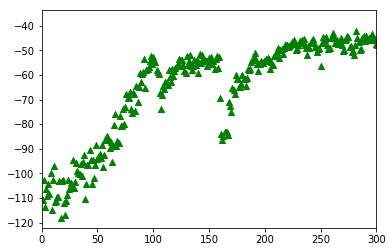

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
ax.set_xlim(0, 300)
plt.show()

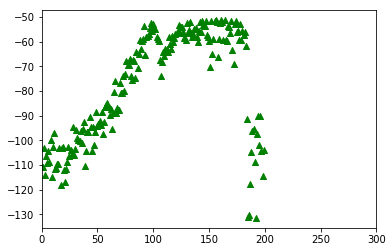

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
ax.set_xlim(0, 300)
plt.show()

In [17]:
save_path = ddpg.saver.save(ddpg.sess, ddpg.model_path)

### Skill Notes for Code:

    saver = tf.train.Saver()
    model_path = "./model_path/"
    save_path = saver.save(ddpg.sess, model_path)
    load_path = saver.restore(ddpg.sess, model_path)